**Проект Яндекс.Практикума. Сборный проект (воронки, А/А/В тест)**

**Курс: Аналитик данных**

---



**СОДЕРЖАНИЕ**

---
[**Описание проекта**](#description)

[**Импорт библиотек и загрузка данных**](#loading)

[**Предобработка данных**](#preparing)

[**Исследовательский анализ данных (EDA)**](#EDA)

[**Сегментация клиентов банка**](#segmentation)

[**Формулировка и проверка статистических гипотез**](#hypotheses)

[**Выводы и рекомендации**](#summary)

---




## **Описание проекта**<a  class="anchor" id="description"></a>



---


**Описание данных**



---



---



##  **Импорт библиотек и загрузка данных**<a  class="anchor" id="loading"></a>

In [1]:
# импортируем библиотеки для работы с данными, построения моделей и 
import pandas as pd
import datetime as dt
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import seaborn as sns


import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# устанавливаем параметры отображения данных
pd.set_option("precision", 2)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.width', 120)
sns.set(style="whitegrid")

In [3]:
# загружаем данные
try:
    logs=pd.read_csv(' ',sep='\t')
    
except:
    url='https://drive.google.com/file/d/ /view?usp=sharing'
    url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
    logs = pd.read_csv(url2,sep='\t')



---



---




## **Предобработка данных**<a  class="anchor" id="preparing"></a>

**Общая информация о данных**

In [4]:
def check_dataset(dataset):
    """
    Функция для вывода информации о структуре и типах данных датафрейма, проверки на пропуски в столбцах и дубликаты записей
    Принимает на вход датафрейм
    Выводит информацию о:
    типах данных, наименовании столбцов и количестве записей в датафрейме;
    наличии пропусков в данных и их долей по столбцам;
    наличии и количестве дубликатов записей;
    десять случайных записей из датафрейма
    """
    try:
        name =[x for x in globals() if globals()[x] is dataset][0]
        cols=len(dataset.columns) if len(dataset.columns)<pd.get_option('display.max_columns') else pd.get_option('display.max_columns')
        width = pd.get_option('display.max_colwidth')*cols
        print('\033[1m','Проверка таблицы: {}'.format(name),'\033[0m')
        print('.'*width)
        print('\033[1m','\nИнформация о типах данных:', '\033[0m')
        display(dataset.info())
        print('.'*width)
        if dataset.isna().mean().sum()==0:
            print('\033[1m', '\nПропусков в столбцах \033[32;1m НЕТ', '\033[0m')
        else:
            print('\033[1m', '\nДоля пропусков в столбцах:', '\033[0m')
            display(pd.DataFrame(round((dataset.isna().mean()*100),2)))
        print('.'*width)
        if dataset.duplicated().sum()==0:
            print('\033[1m', '\nДубликатов строк НЕТ', '\033[0m')
        else:
            print('\033[1m', '\nКоличество дубликатов: \033[31;1m{}\033[0m'.format(dataset.duplicated().sum()))
        print('.'*width)
        print('\033[1m', '\n10 случайных строк датафрейма', '\033[0m')
        display(dataset.sample(10))
           
    except:
        print('Ошибка')

In [5]:
check_dataset(logs)

 Проверка таблицы: logs 
................................................................................................................................................................
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

................................................................................................................................................................
 
Пропусков в столбцах  НЕТ 
................................................................................................................................................................
 
Количество дубликатов: 413
................................................................................................................................................................
 
10 случайных строк датафрейма 


,EventName,DeviceIDHash,EventTimestamp,ExpId
55826,CartScreenAppear,3465976068272903092,1564747958,248
21385,MainScreenAppear,3032338719854871114,1564666146,247
138104,MainScreenAppear,7092770789375305513,1564946725,247
85748,MainScreenAppear,1010439893181060015,1564827892,246
90294,MainScreenAppear,4063315612183415901,1564834395,246
157210,MainScreenAppear,3051480192517827706,1565008774,246
82255,MainScreenAppear,944989533256675646,1564822563,247
193889,PaymentScreenSuccessful,6932517045703054087,1565095278,248
111982,CartScreenAppear,197027893265565660,1564901693,246
38568,Tutorial,3473691793382022823,1564697510,248


Выведем 5 случайных строк таблицы "Логи":

In [6]:
logs.sample(n=5,random_state=42)

,EventName,DeviceIDHash,EventTimestamp,ExpId
100536,PaymentScreenSuccessful,2910761286178294850,1564850670,248
243827,MainScreenAppear,4164287718073415198,1565210495,246
222854,MainScreenAppear,499118262689586521,1565171733,247
33362,MainScreenAppear,3008457239613772584,1564683241,248
16881,CartScreenAppear,197027893265565660,1564659398,246


Таблица "Логи" содержит 243 713 уникальных записей (413 дублированных) по четырем полям. Требуется:
- привести названия полей к удобному виду;
- привести столбец 'EventTimestamp' к формату даты и времени;
- выделить столбец с датой события;
- удалить дубликаты строк.

---



Приведем наименования столбцов к удобному виду:

In [7]:
logs.rename({'EventName' : 'event', 'DeviceIDHash' : 'uid', 'EventTimestamp' : 'timestamp', 'ExpId' : 'group'}, axis=1, inplace=True)

Переведем столбец 'timestamp' в формат даты и времени:

In [8]:
logs['timestamp'] = pd.to_datetime(logs['timestamp'], unit='s')

Добавим столбец с датой события:

In [9]:
logs['date']=logs['timestamp'].dt.date
logs=logs[['event','uid','timestamp','date','group']]

Удалим дубликаты строк:

In [10]:
logs.drop_duplicates(inplace=True);

Выведем 5 строк обновленной таблицы "Логи":

In [11]:
logs.sample(n=5,random_state=42)

,event,uid,timestamp,date,group
240000,CartScreenAppear,2570971451355530886,2019-08-07 18:04:22,2019-08-07,248
233810,CartScreenAppear,2431455045762717569,2019-08-07 15:20:38,2019-08-07,247
180426,MainScreenAppear,8233040176393470157,2019-08-06 05:28:15,2019-08-06,246
12575,MainScreenAppear,438481114985016111,2019-08-01 09:39:31,2019-08-01,247
201095,CartScreenAppear,4877161838950700944,2019-08-06 15:36:16,2019-08-06,247


---


## **Исследовательский анализ данных (EDA)**<a  class="anchor" id="EDA"></a>



Информация по событиям и пользователям:

In [12]:
print('\033[1m','В логе {} уникальных событий, всего событий: {}.'.format(logs.event.nunique(),logs.event.count()),'\033[0m')

 В логе 5 уникальных событий, всего событий: 243713. 


In [13]:
print('\033[1m','В логе всего {} уникальных пользователей.'.format(logs.uid.nunique()),'\033[0m')

 В логе всего 7551 уникальных пользователей. 


В среднем на одного пользователя приходится 32,3 события. Однако стандартное отклонение этого параметра превышает среднее в два раза, и половина пользователей генерирует не более 20 событий.

In [14]:
logs.groupby('uid')['event'].count().describe().apply(lambda x: format(x, '.1f'))

count    7551.0
mean       32.3
std        65.2
min         1.0
25%         9.0
50%        20.0
75%        37.0
max      2307.0
Name: event, dtype: object



---



Определим минимальную и максимальную дату в логах = временной интервал зафиксированных событий.

In [15]:
print('\033[1m','Временной интервал событий лежит в границах от "{}" до "{}".'.format(logs.timestamp.min(),logs.timestamp.max()),'\033[0m')

 Временной интервал событий лежит в границах от "2019-07-25 04:43:36" до "2019-08-07 21:15:17". 


Для построения гистограммы распределения данных о событиях по дате и времени добавим в данные столбец с датой-временем, усеченными до часа совершения события. Это позволит уплотнить данные и улучшить визуализацию распределения.

In [16]:
logs['dt_hour']=logs.timestamp.dt.floor('h')

Отобразим распределение данных о событиях по дате и времени на графике.

In [17]:
def plot_attr(title,xlabel,ylabel):
    ax.title.set_text(title)
    ax.title.set_fontsize(20)
    ax.title.set_color('red')
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    ax.set_facecolor('azure')

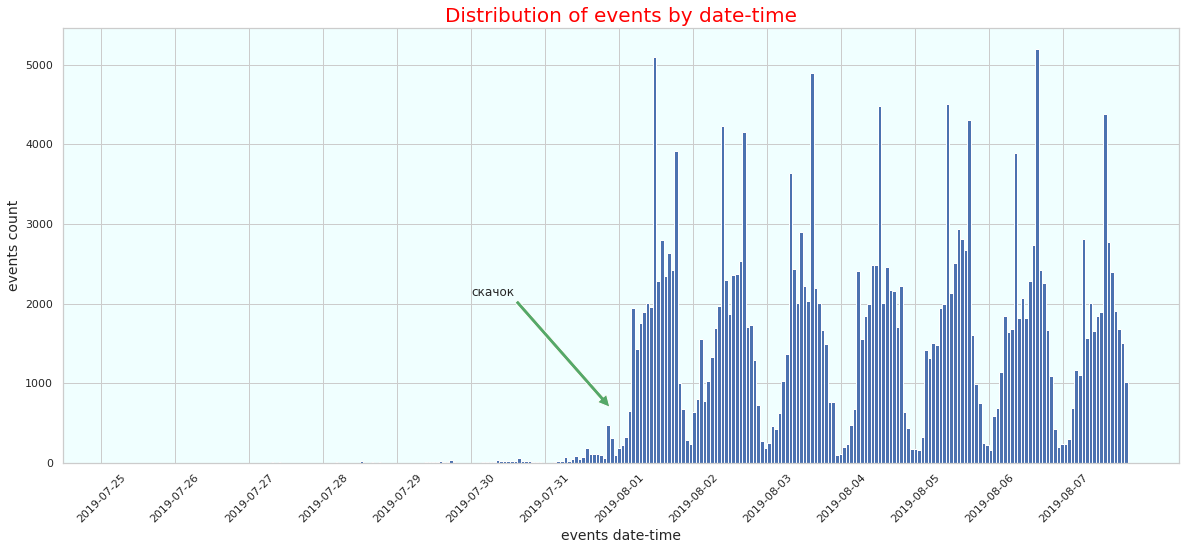

In [18]:
fig,ax = plt.subplots(figsize=(20, 8))
plt.hist(logs.dt_hour,bins=logs.dt_hour.nunique())
title='Distribution of events by date-time'
xlabel='events date-time'
ylabel='events count'
plot_attr(title,xlabel,ylabel)
plt.xticks(logs.date.unique(),rotation=45)
plt.annotate('скачок', xy=(pd.to_datetime("2019-07-31 21:00:00"), 700), xytext=(pd.to_datetime("2019-07-30"), 2100),
            arrowprops=dict(facecolor='g'))
plt.show();

График показывает, что данные лога о событиях не обладают полнотой на протяжении номинального временного периода. Определим дату, в которой происходит резкое измнение количества регистрируемых событий.

In [19]:
logs_date_pivot=logs.pivot_table(index='date',values='event',aggfunc='count').reset_index()
logs_date_pivot['count_ratio']=logs_date_pivot['event'].pct_change()
logs_date_pivot[logs_date_pivot.count_ratio==logs_date_pivot.count_ratio.max()]


,date,event,count_ratio
7,2019-08-01,36141,16.8


Объем данных о событиях за 01.08.2019 превышает объем зарегистрированных данных предыдущего дня в 16,8 раза. Определим с точностью до часа левую границу временного интервала, данные за который полны и пригодны для дальнейшего анализа. 

Построим распределение логов по часам за период с 31.07.2019 по 01.08.2019 в разрезе событий.

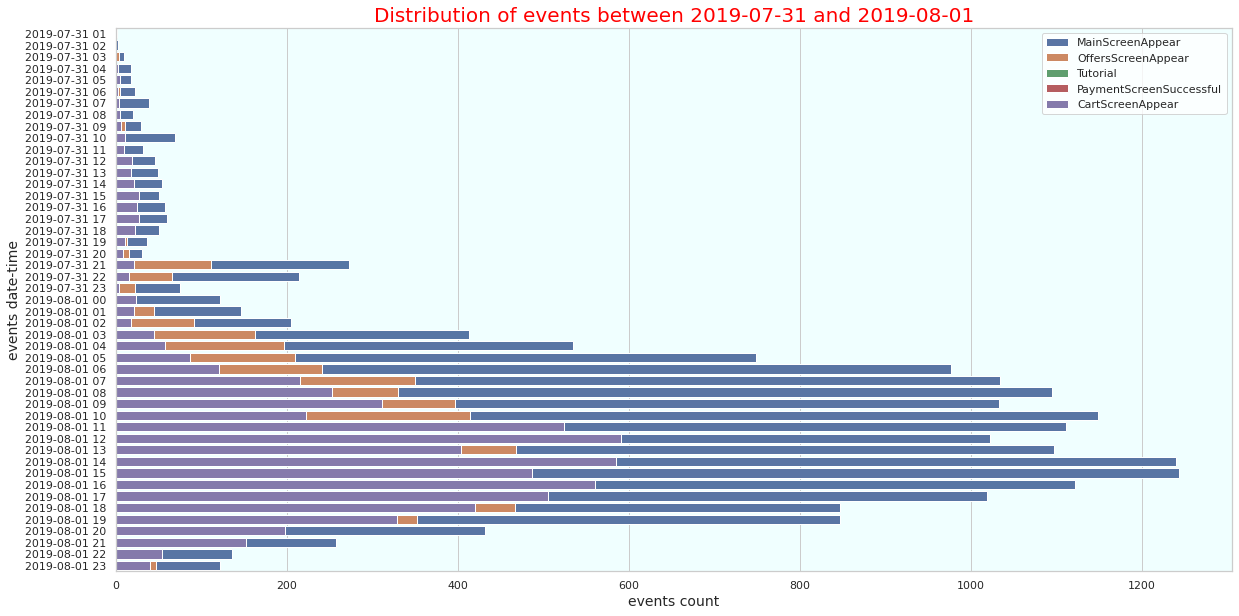

In [20]:
df=logs.query('date>=@pd.to_datetime("2019-07-31") and date<=@pd.to_datetime("2019-08-01")')

fig,ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(y=df['dt_hour'].dt.strftime('%Y-%m-%d %H'), hue='event', data=df, dodge=False)
title='Distribution of events between 2019-07-31 and 2019-08-01'
xlabel='events count'
ylabel='events date-time'
plot_attr(title,xlabel,ylabel)
ax.legend(loc='upper right')
fig.show() 

Резкое изменение количества регистрируемых событий просходит в 21 час 31.07.2019. Таким образом, период, содержащий полные данный, который будет использован для дальнейшего анализа, сокращается до интервала с 31.07.2019 21:00 до 07.08.2019 21.15.

---



Создадаим датафрейм, содержащий логи пользователей за релевантный период и рассчитаем потери данных в результате сокращения временного интервала.

In [21]:
logs_rel=logs.query('timestamp>=@pd.to_datetime("2019-07-31 21:00:00")').copy()

In [22]:
logs_rel.groupby('uid')['event'].count().describe().apply(lambda x: format(x, '.1f'))

count    7538.0
mean       32.1
std        65.2
min         1.0
25%         9.0
50%        19.0
75%        37.0
max      2307.0
Name: event, dtype: object

In [23]:
print('\033[1m','В обновленном логе {} уникальных событий, всего событий: {}. Количество событий сократилось на {:.1%}.'.\
      format(logs_rel.event.nunique(),logs_rel.event.count(),(logs_rel.event.count()-logs.event.count())/logs.event.count()),'\033[0m')

 В обновленном логе 5 уникальных событий, всего событий: 241724. Количество событий сократилось на -0.8%. 


In [24]:
print('\033[1m','В обновленном логе всего {} уникальных пользователей. Количество пользователей сократилось на {:.1%}.'.\
      format(logs_rel.uid.nunique(),(logs_rel.uid.nunique()-logs.uid.nunique())/logs.uid.nunique()),'\033[0m')

 В обновленном логе всего 7538 уникальных пользователей. Количество пользователей сократилось на -0.2%. 


Построим на графике распределение данных о зарегистрированных событиях за релевантный период в разрезе групп.

In [25]:
df=logs_rel.groupby(['date','group'])['event'].count().reset_index()

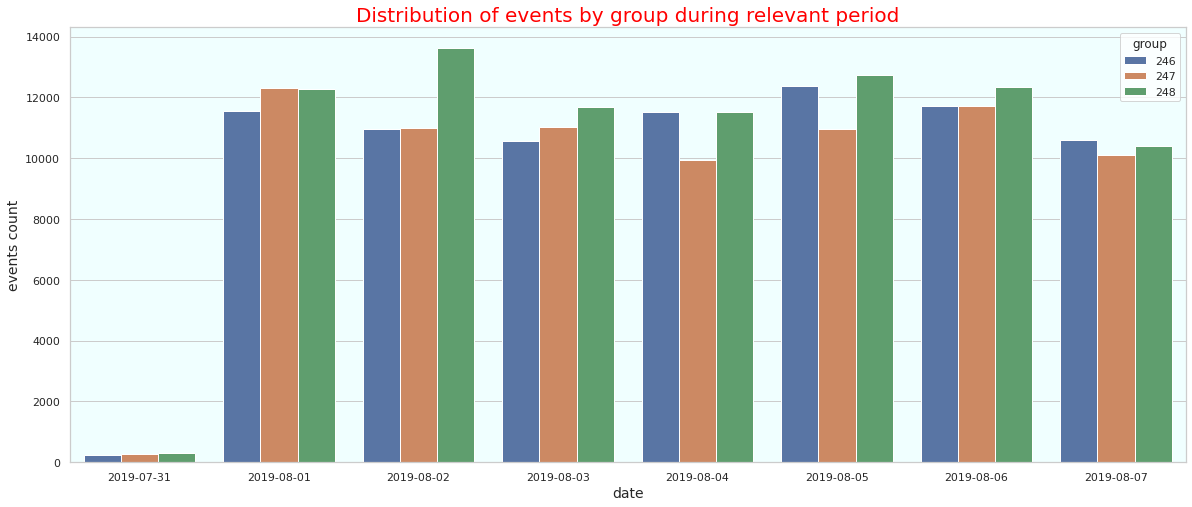

In [26]:
fig,ax = plt.subplots(figsize=(20, 8))
ax=sns.barplot(x='date', y='event', hue='group',data=df)
title='Distribution of events by group during relevant period'
xlabel='date'
ylabel='events count'
plot_attr(title,xlabel,ylabel)
fig.show() 

В логах за релевантный период содержатся данные о событиях для всех групп пользователей. В результате сокращения временного интервала логов данные о событиях сократились на 0,8%, база пользователей уменьшилась на 0,2%.

---



##  **Изучение воронки событий**<a  class="anchor" id="funnel"></a>

Для анализа воронки событий создадам датафрейм, сгруппировав логи по наименованию события и рассчитав количество событий и число сгенерировавших их пользователей. также рассчитаем долю пользователей, хотя бы раз генерировавших конкретное событие.

In [27]:
events = logs_rel.groupby('event')['uid'].agg(['count', 'nunique']).reset_index()
events.columns =['event', 'events_cnt', 'users_cnt']
events['users_share']=events['users_cnt']/logs_rel.uid.nunique()

Отобразим частоту событий, количество и долю пользователей, сгенерировавших события от общего числа пользователей в логах,  на графиках, упорядочив данные по убыванию значений.

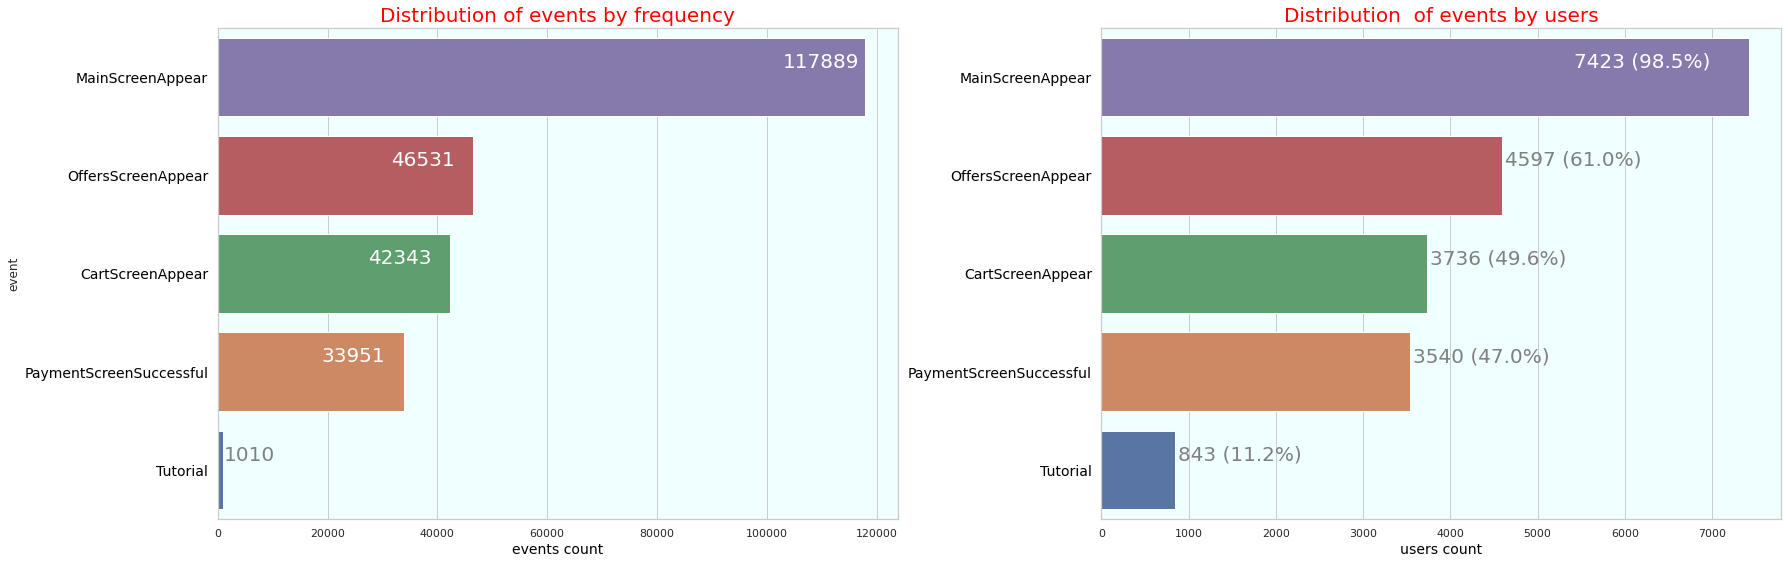

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25, 8))
order = events.sort_values('events_cnt').reset_index(drop=True)['event']
sns.barplot(ax=axes[0], y='event', x='events_cnt', order = order,  data=events)
axes[0].set_yticklabels(order, fontsize=14,color='black')
axes[0].invert_yaxis()
axes[0].set_xlabel('events count', fontsize=14,color='black')
axes[0].set_title('Distribution of events by frequency')
axes[0].title.set_fontsize(20)
axes[0].title.set_color('red')
for i in axes[0].patches:
    if i.get_width() > 20000:
        axes[0].text(i.get_width()-15000, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='white')
    else:
        axes[0].text(i.get_width()+30, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='grey')
axes[0].set_facecolor('azure')

order = events.sort_values('users_cnt').reset_index(drop=True)['event']
sns.barplot(ax=axes[1],y='event', x='users_cnt', order = order,  data=events)
axes[1].set_yticklabels(order, fontsize=14,color='black')
axes[1].set_ylabel(None)
axes[1].invert_yaxis()
axes[1].set_xlabel('users count', fontsize=14,color='black')
axes[1].set_title('Distribution  of events by users')
axes[1].title.set_fontsize(20)
axes[1].title.set_color('red')
for i in axes[1].patches:
    if i.get_width() > 5000:
        axes[1].text(i.get_width()-2000, i.get_y()+0.5, 
                str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / logs_rel.uid.nunique()), fontsize=20, color='white')
    else:
        axes[1].text(i.get_width()+30, i.get_y()+0.5, 
                str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / logs_rel.uid.nunique()), fontsize=20, color='grey')
axes[1].set_facecolor('azure')
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.show()



---

Логичным порядком событий, регистрирующих отдельные этапы законченного алгоритма поведения пользователя, является:
1. Появление основного экрана (MainScreenAppear);
2. Появление экрана с каталогом (OffersScreenAppear);
3. Появление экрана с корзиной (CartScreenAppear);
4. Появление экрана с успешной оплатой (PaymentScreenSuccessful).

Пятое по популярности событие в логах: переход в руководство пользователя(Tutorial) может следовать перед и после любого из вышеперечисленных событий и является тангенциальным воронке регистрации продаж.

Сгруппируем данные по событиям и группам с расчетом количества пользователей.

In [29]:
events_gr = logs_rel[ logs_rel['event'] != 'Tutorial'].groupby(['event','group'])['uid'].agg('nunique').reset_index()

Определим явно порядок событий в воронке и сохраним в переменной.

In [30]:
steps=['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

Рассчитаем размеры групп эксперимента.

In [31]:
group_246_total=logs_rel.query('group==246')['uid'].nunique()
group_247_total=logs_rel.query('group==247')['uid'].nunique()
group_248_total=logs_rel.query('group==248')['uid'].nunique()

Отобразим на графике число и долю пользователей на каждом шаге воронки по группам.

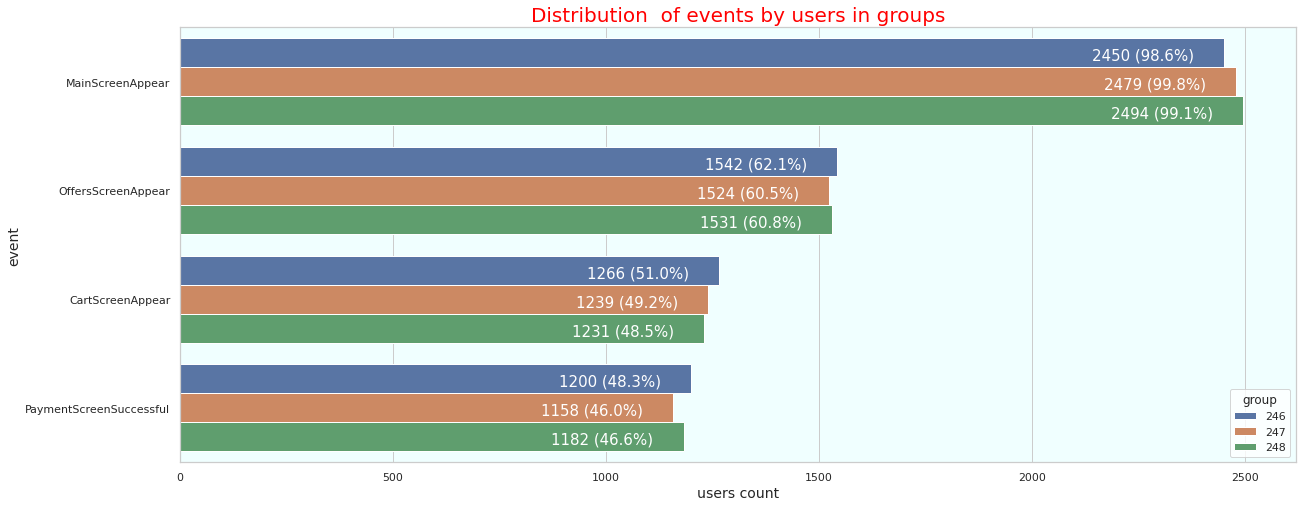

In [32]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(y='event', x='uid', order = steps, hue='group', data=events_gr)
ax.set_title('Share of users in groups that have passed the event at least once')
for i,v in enumerate(ax.patches):
    if i < 5:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / group_246_total),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / group_246_total),
                    fontsize=15, color='grey')
    if 5 <= i < 10:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / group_247_total),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / group_247_total),
                    fontsize=15, color='grey')
    if i >= 10:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / group_248_total),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / group_248_total),
                    fontsize=15, color='grey')
title='Distribution  of events by users in groups'
xlabel='users count'
ylabel='event'
plot_attr(title,xlabel,ylabel)
plt.show()



---

Построим воронку событий рассчитав, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [33]:
def funnel(steps,steps_val,ylabel,title_text):
    fig = go.Figure(
        go.Funnel(
            y = steps,
            x = steps_val,
            textinfo = "value+percent previous")
    )
    fig.update_layout(
        yaxis_title=ylabel,
        title={
        'text': title_text,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        font={
            'size':18
        }    
    )
    fig.show()

In [34]:
steps = events[events['event'] != 'Tutorial'].sort_values('users_cnt',ascending=False).reset_index(drop=True)['event']
steps_val = events[events['event'] != 'Tutorial'].sort_values('users_cnt',ascending=False).reset_index(drop=True)['users_cnt']
ylabel="event"
title_text="Funnel of events by users"
funnel(steps,steps_val,ylabel,title_text)

Наибольшее количество пользователей "теряется" при переходе с первого шага воронки на второй: число перешедших на страницу каталога на 38% меньше количества пользователей, открывших главную страницу.

Помимо естественных причин оттока пользователей (случайное открытие, не соотвествие тематики интересам и прочее), этот факт может свидетельствовать о проблемах с дизайном main-page, кросс-браузерными, кросс-платформенными проблемами отображения, сложной для пользователя маршрутизацией и т.д. Требуется более детально исследование этого факта.



---

Определим пользователей, последовательно проходящих от первого события до оплаты.

In [35]:
full_step_users = logs_rel[ logs_rel['event'] != 'Tutorial'].pivot_table(index=['uid'], columns='event', values='timestamp', aggfunc='min').reset_index()
full_step_users['one_steps_flag'] = (~full_step_users['MainScreenAppear'].isna())
full_step_users['two_steps_flag'] = full_step_users['one_steps_flag'] & (full_step_users['OffersScreenAppear'] > full_step_users['MainScreenAppear'])
full_step_users['three_steps_flag'] = full_step_users['two_steps_flag'] & (full_step_users['CartScreenAppear'] > full_step_users['OffersScreenAppear'])
full_step_users['all_steps_flag'] = full_step_users['three_steps_flag'] & (full_step_users['PaymentScreenSuccessful'] > full_step_users['CartScreenAppear'])

Построим воронку событий для пользователей, генерирующих события в соотвествии с предполагаемым порядком действий.

In [36]:
steps_val = [full_step_users['one_steps_flag'].sum(),full_step_users['two_steps_flag'].sum(), full_step_users['three_steps_flag'].sum(), full_step_users['all_steps_flag'].sum()]
ylabel="event"
title_text="Funnel of events step-by-step users"
funnel(steps,steps_val,ylabel,title_text)

Изучение воронки событий для пользователей, генерирующих события в соотвествии с предполагаемым порядком действий, позволяет определеить еще одно узкое место приложения: при переходе от корзины до завершения оплаты "теряется" две трети пользователей. Это может свидетельствовать о наличии проблем как с дизайном приложения, так и с работой api платежной системы или доступными вариантами оплаты.

In [37]:
print('\033[1m','Доля пользователей, последовательно прошедших 4 шага воронки: {:.1%}.'.\
      format(full_step_users.all_steps_flag.sum()/len((~full_step_users['MainScreenAppear'].isna()))),'\033[0m')

 Доля пользователей, последовательно прошедших 4 шага воронки: 6.1%. 


Маленькая доля пользователей, последовательно прошедших все четыре шага воронки, может свидетельствовать о том, что главная страница не является единственным стартовым лендингом для сессии, завершающейся заказом. Скорее всего, часть заказов несколько дублирующих шагов проходит либо на маркетплейсах, либо на других страницах приложения.

---



##  **Изучение результатов эксперимента**<a  class="anchor" id="testing"></a>

Определим размеры групп эксперимента и проиллюстрируем их соотношение на графике.

In [38]:
df=logs_rel.pivot_table(index='group',values='uid',aggfunc=['nunique']).reset_index()
df.columns=['group','users_cnt']

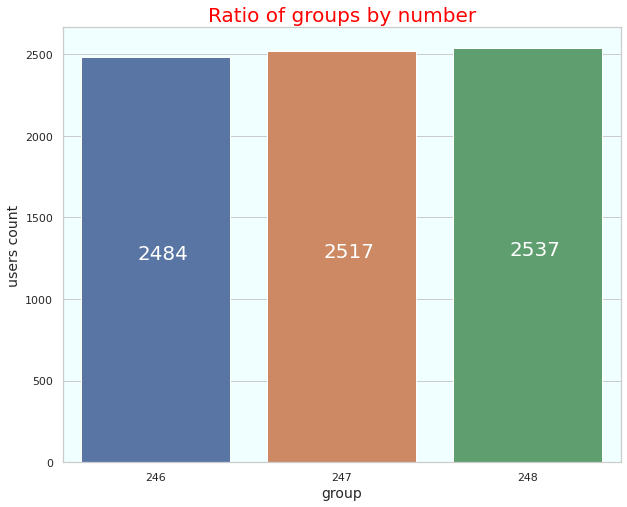

In [39]:
fig,ax = plt.subplots(figsize=(10, 8))
ax=sns.barplot(x='group', y='users_cnt', data=df)
title='Ratio of groups by number'
xlabel='group'
ylabel='users count'
for i, v in enumerate(df['users_cnt']):
            if isinstance(v, float): v=round(v,2)
            ax.text(i-0.1,v*0.5, str(v), fontsize=20,color='white')
plot_attr(title,xlabel,ylabel)
fig.show() 

Группы пользователей, сформированные в результате проведения эксперимента, практически равны по численности.

---



При выборе критического уровня значимости необходимо обращать внимание на объем выборки. При увеличении объема выборки случайные отклонения компенсируют друг друга, и получить значимое различие в выборках при их однородности менее вероятно. При больших выборках, измеряемых тысячами наблюдений (в нашем случае наблюдением является поведение каждого пользователя), уверенно отвергать нулевую гипотезу можно только при значимости меньшей 0,01.
Примем уровень значимости альфа равным 0,01.

---



Сформируем датафреймы по группам эксперимента:

In [40]:
group_246=logs_rel.query('group==246').copy()
group_247=logs_rel.query('group==247').copy()
group_248=logs_rel.query('group==248').copy()



---


Проверим однородность контрольных групп, 246 и 247. Сформулируем нулевую гипотезу: среднее количество событий, генерируемых пользователями групп 246 и 247 не отличается. Соотвественно, альтернативной гипотезой будет являться: есть статистически значимые различия в средних по выборкам 246 и 247.

Для выбора критерия оценки статистической значимости (t-критерия Стюарта или Манна-Уитни) различий в средних между группами проверим выборки на нормальность распределения данных в самих выборках и t-статистики выборок.
Применим функцию, проверяющую гипотезу о нормальном распределении данных (строящую для данных графики распределения вероятностей (Q-Q plot) и проводящую тест Шапиро-Вилка).

In [41]:
group_246_evmean=group_246.groupby('uid')['event'].agg('count').reset_index()
group_247_evmean=group_247.groupby('uid')['event'].agg('count').reset_index()

In [42]:
def distribution_normality_check(data1,data2,n=10000,s=0.1,alpha=0.001):

    def set_titles(ax,title):
        ax.set_title(title)
        ax.title.set_color('black')
        ax.title.set_size(14)

    sample_size=round(min(len(data1),len(data2))*s)
    result=[]
    for _ in range(n):
        result.append(st.ttest_ind(np.random.choice(np.array(data1),size=sample_size,replace=False),np.random.choice(np.array(data2),size=sample_size,replace=False)).statistic)

    plt.figure(figsize=(21,7))    
    ax1 = plt.subplot2grid((3, 3), (0, 0),rowspan=2)
    st.probplot(data1, dist="norm", plot=plt, rvalue=True)
    set_titles(ax1,'Proximity to the normal distribution (red line) of first sample')
    ax2 = plt.subplot2grid((3, 3), (0, 1),rowspan=2)
    st.probplot(data2, dist="norm", plot=plt,rvalue=True)
    set_titles(ax2,'Proximity to the normal distribution (red line) of second sample')
    ax3 = plt.subplot2grid((3, 3), (0, 2),rowspan=2)
    st.probplot(result, dist="norm", plot=plt,rvalue=True)
    set_titles(ax3,'Proximity to the normal distribution (red line) of t-statistics')
   
    def shapiro_test(data):
        x,y = st.shapiro(data)
        p_value=format(y,'.8f')
        if (y < alpha):
            verdict='Normal distribution of data: rejected'
            passed='no'
        else:
            verdict='Normal distribution of data: not rejected'
            passed='yes'
        return ['p-value = '+p_value+'\n'+verdict,passed]
   
    def plt_text(ax,text,passed):
        if passed=='yes':
            color='green'
        else:
            color='tab:red'
        ax.text(0.5,0.5,text,fontsize='x-large',horizontalalignment='center',verticalalignment='center',linespacing=2,c=color) 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
    
    ax4 = plt.subplot2grid((3, 3), (2, 0))
    test_res=shapiro_test(data1)
    text='Shapiro–Wilk test for first sample:\n'+test_res[0]
    plt_text(ax4,text,test_res[1])
    
    ax5 = plt.subplot2grid((3, 3), (2, 1))
    test_res=shapiro_test(data2)
    text='Shapiro–Wilk test for second sample:\n'+test_res[0]
    plt_text(ax5,text,test_res[1])

    ax6 = plt.subplot2grid((3, 3), (2, 2))
    test_res=shapiro_test(result)
    text='Shapiro–Wilk test for t-statistics:\n'+test_res[0]
    plt_text(ax6,text,test_res[1])

    plt.tight_layout()
    plt.show() 

Сформулируем нулевую гипотезу проверки на нормальность: данные в выборках 246 и 247 распределены нормально и  для оценки статистической значимости различий в их средних может быть использован дисперсионный анализ или t-критерий Стюарта.
Соотвественно, альтернативной гипотезой будет: распределение данных в выборках 246 и 247 отличается от нормального и для оценки статистической значимости различий в их средних следует использовать критерий Манна-Уитни.

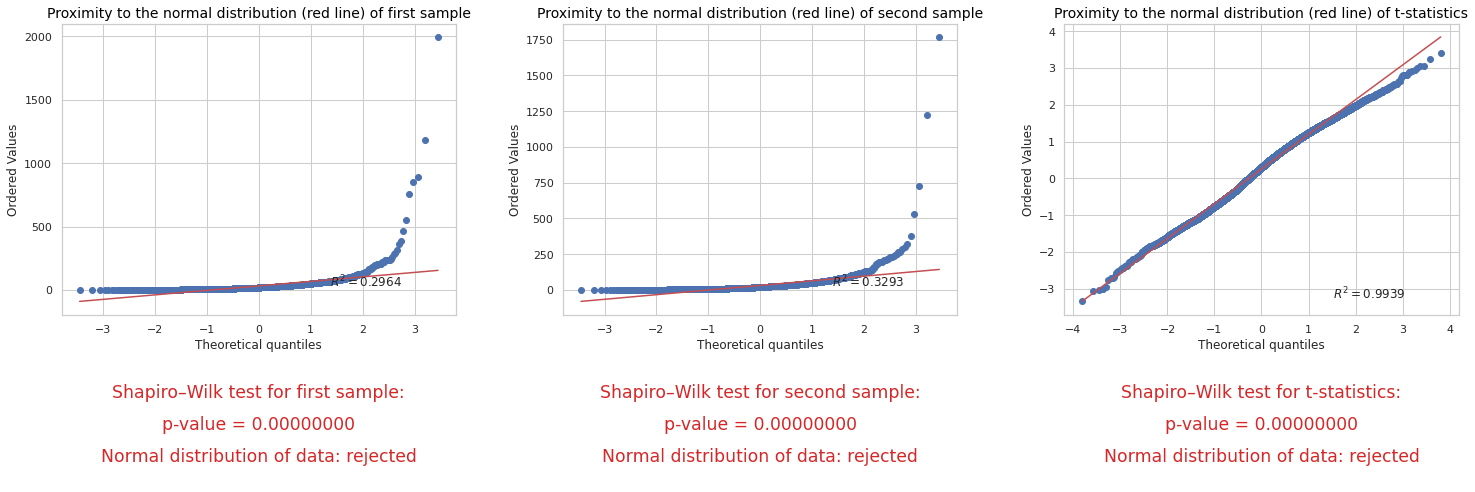

In [43]:
distribution_normality_check(group_246_evmean.event,group_247_evmean.event)

Отвергаем гипотезу о нормальности распределания данных. 

Для проверки нулевой гипотезы о том, что среднее количество событий, генерируемых пользователями групп 246 и 247 не отличается, применим критерий Манна-Уитни. Пороговый уровень значимости примем в 1% (alpha=0.01). 

In [44]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(group_246_evmean.event,group_247_evmean.event, alternative="two-sided")[1]))

p-value: 0.807


Вероятность получить подобные или еще более выраженные отклонения средних из этих двух выборок при условии верности нулевой гипотезы превышает пороговое значение уровня значимости. **Вывод:** не отвергаем нулевую гипотезу. Нельзя утверждать, что среднее количество событий по группе эксперимента 246 отличается от среднего количества событий по группе эксперимента 247.

Проверим с помощью пропорционального z-теста, будет ли отличие между группами статистически достоверным. 

In [45]:
def perform_ztest(group_A,group_B,group_A_name,group_B_name,steps,alpha=0.01):
    plt.figure(figsize=(25,7))
    plt.suptitle('Share of users having events in group '+group_A_name+' and '+group_B_name, y=1.05, fontsize=22,color='red')
    
    def set_titles(ax,title):
        ax.set_title(title)
        ax.title.set_color('black')
        ax.title.set_size(20)
        ax.set_ylabel('share of users')
        ax.set_xlabel('groups')
        ax.set_ylim(0,1)
    
    def plt_text(ax,text,passed):
        if passed=='yes':
            color='green'
        else:
            color='tab:red'
        ax.text(0.5,0.5,text,fontsize='x-large',horizontalalignment='center',verticalalignment='center',linespacing=2,c=color) 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    total_A=group_A.uid.nunique()
    total_B=group_B.uid.nunique()
    p_vals=[]

    for i in range(len(steps)):
        pozitive_A=group_A[group_A['event']==steps[i]].uid.nunique()
        pozitive_B=group_B[group_B['event']==steps[i]].uid.nunique()
        share_A=pozitive_A/total_A
        share_B=pozitive_B/total_B

        ax=plt.subplot2grid((3, 4), (0, i),rowspan=2)
        sns.barplot(ax=ax, x=[group_A_name,group_B_name], y=[share_A,share_B])
        set_titles(ax,steps[i])
        for ind, v in enumerate([share_A,share_B]):
            if isinstance(v, float): v=round(v,2)
            ax.text(ind-0.1,v*0.5, str(v), fontsize=20,color='white')
        

        p_vals.append(proportions_ztest(
        [pozitive_A,pozitive_B],
        [total_A,total_B])[1])
    
    p_correction=multipletests(p_vals, alpha, method='holm')
    
    for i in range(len(steps)):
        if p_correction[0][i]:
            verdict='H0 rejected'
            passed='no'
        else:
            verdict='H0 not rejected'
            passed='yes'
        
        text='multitest corrected \n p-value = '+str(round(p_correction[1][i],5))+'\n'+verdict
        plt_text(plt.subplot2grid((3, 4), (2, i)),text,passed)
   
    plt.tight_layout()
    plt.show() 

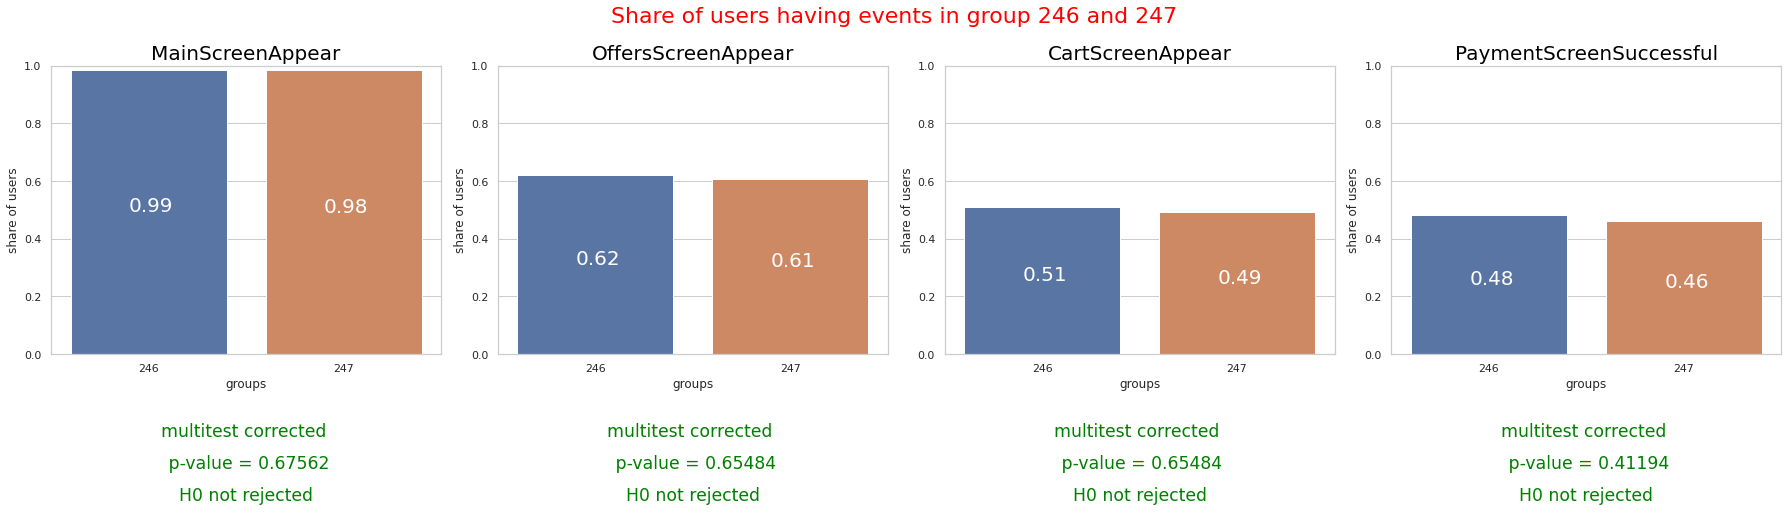

In [46]:
perform_ztest(group_246,group_247,'246','247',steps)

Результаты z-теста не позволяют отвергнуть нулевую гипотезу об отсутствии различий между группами в долях пользователей, сгенерировавших то или иное событие по всем ступеням воронки продажи. 
На основании проведенных U и Z тестов, группы 246 и 247 можно признать контрольными.

---



Сформулируем нулевую гипотезу А/В теста: статистически значимые различия в пропорциях контрольных и экспериментальной групп отсуствуют.

Проверим статистическую значимость различий параметров между контрольной группой 246 и экспериментальной группой 248:

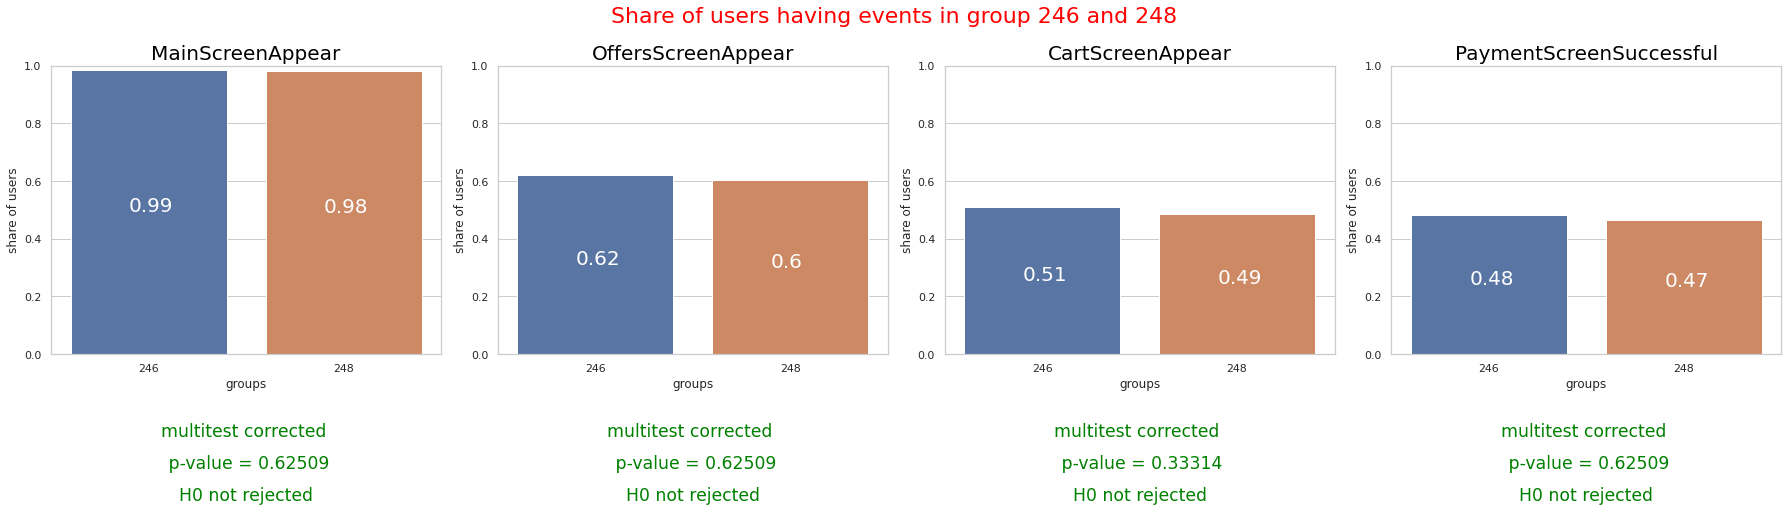

In [47]:
perform_ztest(group_246,group_248,'246','248',steps)

Проверим статистическую значимость различий параметров между контрольной группой 247 и экспериментальной группой 248:

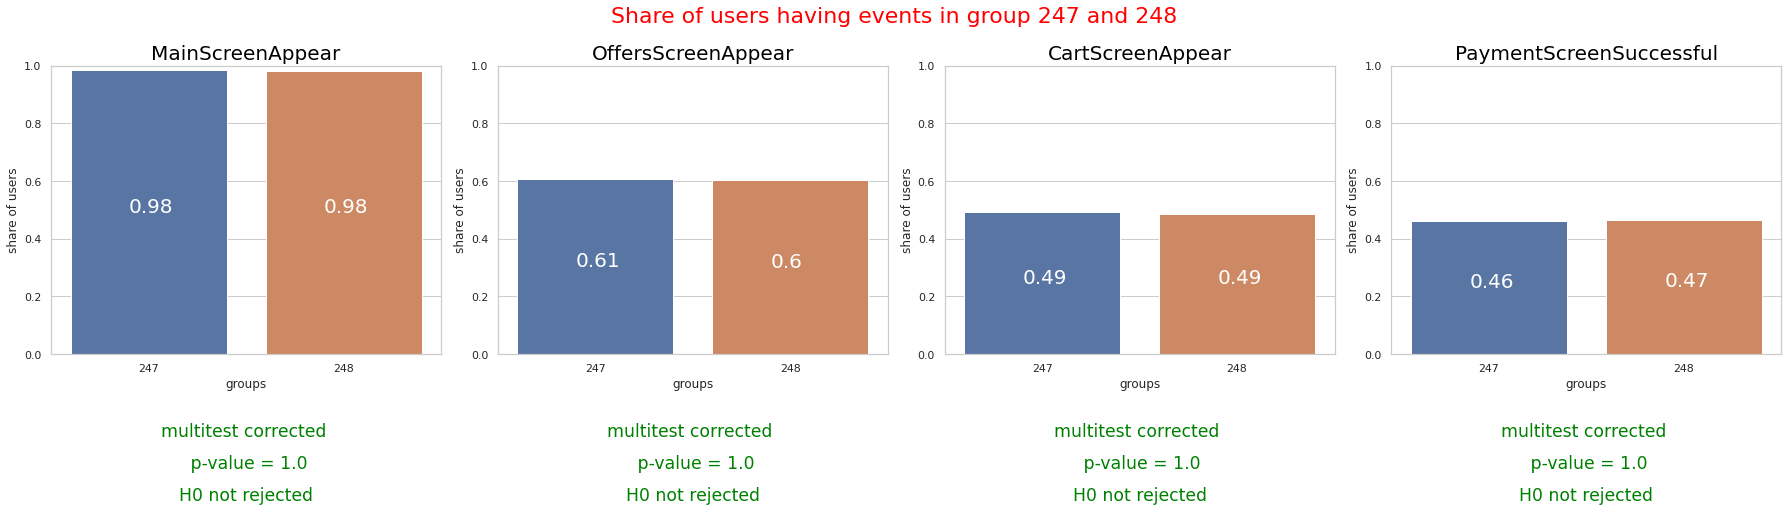

In [48]:
perform_ztest(group_247,group_248,'247','248',steps)

Проверим статистическую значимость различий параметров между объединенной контрольной группой 246+247 и экспериментальной группой 248:

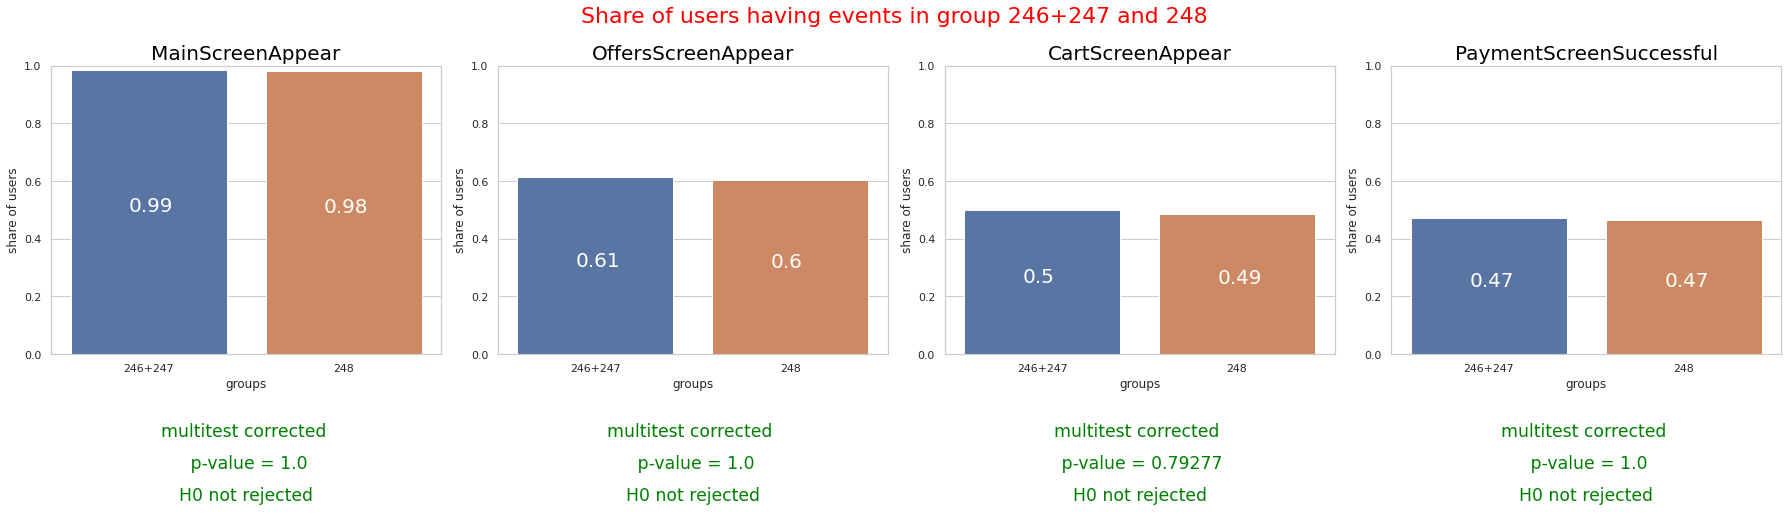

In [49]:
perform_ztest(pd.concat([group_246,group_247]),group_248,'246+247','248',steps)

Ни один из тестов не отверг нулевую гипотезу ни по одному событию, а, следовательно, наличие статистической значимости различий параметров между контрольными группами и экспериментальной группой подтвердить невозможно.

##  **Выводы**<a  class="anchor" id="summary"></a>

Для проведения А/В теста использованы данные о поведении трех групп пользователей (две контрольных и одна экспериментальная) в виде логов мобильного приложения за период с 31.07.2019 по 07.08.2019. Группы эксперимента однороды по поведению пользователей, медианное количество на одного пользователя составило 19 событий.

Воронкой продаж по исследованным логам мы приняли последовательность событий: Появление основного экрана (MainScreenAppear)-> Появление экрана с каталогом (OffersScreenAppear) -> Появление экрана с корзиной (CartScreenAppear) -> Появление экрана с успешной оплатой (PaymentScreenSuccessful).  

По результатам анализа событий по количеству пользователей их иннициировавших по данным по всем группам выяснилось, что событие "Появление основного экрана" зарегистрровано для 98,5% пользователей. Сделан вывод о возможном стартовом лендинге в приложении помимо главной страницы. 

Каталог товаров открывал 61% пользователей, что является самой большой ступенью в воронке продаж. Рекомендовано было проведение дополнительного исследования наличия возможных проблем отображения или маршрутизации пользователей между главной страницей и страницей каталога.

В корзину перешли 49,6% пользователей и оформили покупку, успешно совершив оплату 47% пользователей.

Анализ по покупателям, совершавшим последовательные действия по ступениям воронки продаж, выявил, что из пользователей, открывших главную страницу, через каталог и корзину, завершили покупку оплатой лишь 6,1%.

Так как успешно совершали оплату 47% пользователей, то такая маленькая доля покупок в результате последовательных шагов позволяет сделать вывод о наличии альтернативных путей завершения транзакций.
Также определено потенциальное узкое место приложения: при переходе из корзины к оплате отсеивается 2/3 пользователей. Требуется дополнительная диагностика выявленной аномалии. 

Анализ контрольных групп 246 и 247 на однородность (тест Манна-Уитни для проверки гипотезы о равенстве средних двух групп и z-тест для проверки статзначимости пропорций в группах) подтвердил корректность разбиения на группы.

Для проверки влияния измнения шрифта в приложении на поведение пользователей проведено 12 тестов, ни один из которых не показал наличия статистически значимого различия в группах. Таким образом, нельзя утверждать, что изменение текста окажет позитивное, либо негативное влияние на пользователей приложения.